## This example uses Shack Hartmann Wavefront Sensor

In [1]:
import sys
sys.path.insert(1, '../../hcipy')

In [2]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [3]:
wavelength_wfs = 842.0E-9 # meter
telescope_diameter = 6.5 # meter
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0r


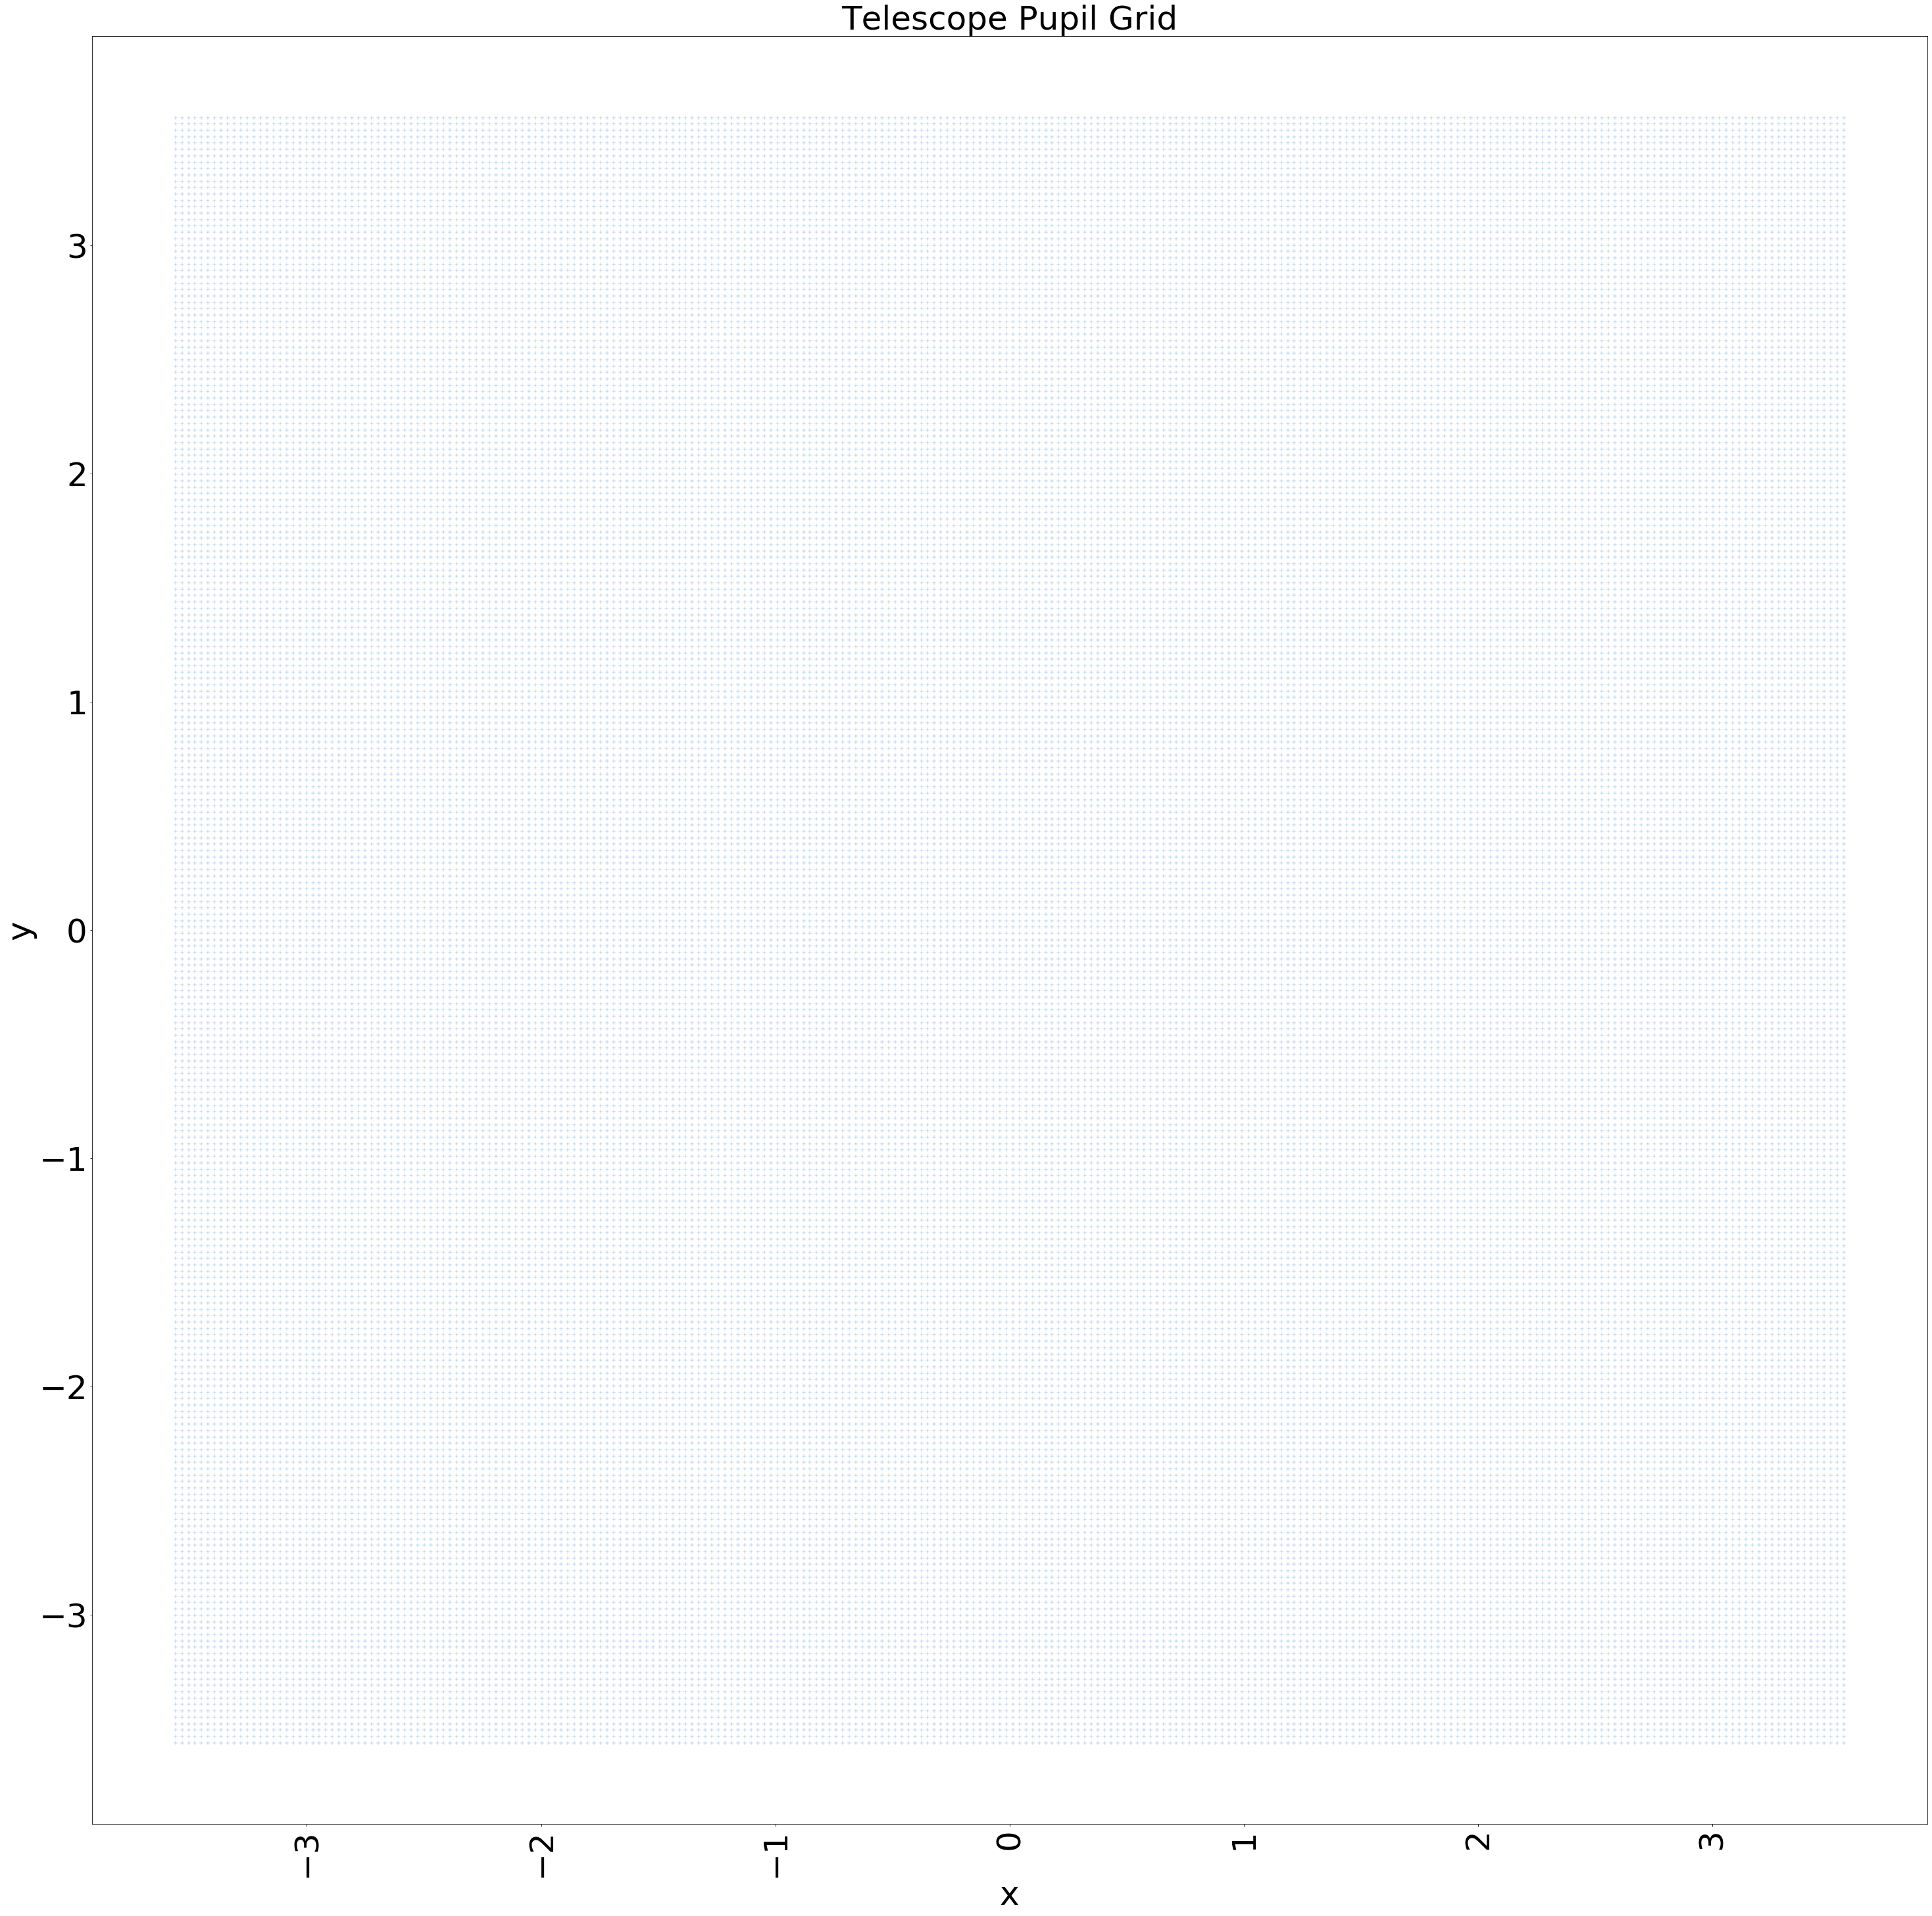

In [4]:
N = 256
telescope_pupil_grid  = make_pupil_grid(N, telescope_diameter*1.1)
## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(telescope_pupil_grid.x, telescope_pupil_grid.y, '+')
plt.title('Telescope Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

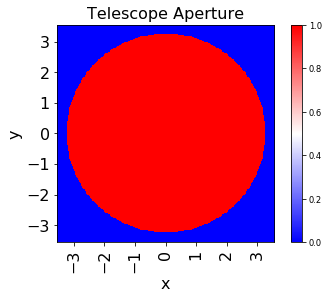

In [5]:
telescope_aperture = circular_aperture(telescope_diameter)
#telescope_aperture_grid = evaluate_supersampled(telescope_aperture, telescope_pupil_grid, 6)

telescope_aperture_grid = telescope_aperture(telescope_pupil_grid)
imshow_field(telescope_aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Telescope Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

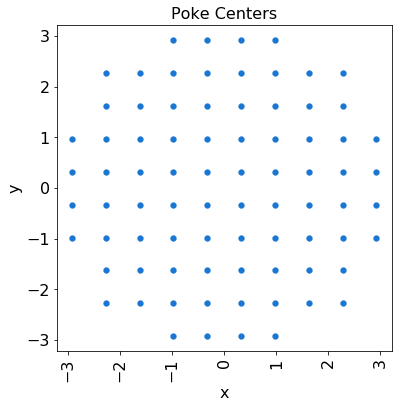

In [6]:
# Make deformable Mirror
num_actuators = 10
pitch = telescope_diameter / num_actuators
poke_centers = make_pupil_grid(num_actuators, telescope_diameter)

poke_centers = poke_centers.subset(poke_centers.as_('polar').r < telescope_diameter / 2)

## Just plotting something
plt.figure(figsize=(6,6))
plt.plot(poke_centers.x, poke_centers.y, 'o')
plt.title('Poke Centers',fontsize=16)
xfont = plt.xlabel('x', fontsize=16)
yfont = plt.ylabel('y', fontsize=16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

Num of modes = 80


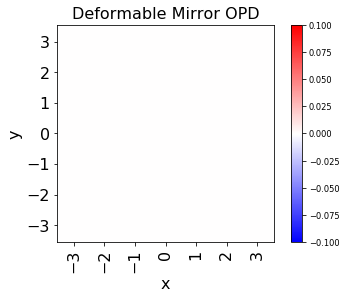

In [7]:
dm_modes = make_gaussian_pokes(telescope_pupil_grid, poke_centers,
                              pitch*np.sqrt(2))
num_modes = poke_centers.x.size
print('Num of modes = {:g}'.format(num_modes))
deformable_mirror = DeformableMirror(dm_modes)

imshow_field(deformable_mirror.opd, cmap = 'bwr')
plt.colorbar()
plt.title('Deformable Mirror OPD', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [8]:
# Create the Shack-Hartmann Wavefront Sensor
# (mla stands for micro lens array)
F_mla = 20. /0.3 # F-Number (F-Number = Focal Length/Diameter)
N_mla = 22 # Number of lenslet
'''
SquareShackHartmannWavefrontSensorOptics(
    input_grid,
    f_number,
    num_lenslets,
    pupil_diameter,
)
'''
shwfs = SquareShackHartmannWavefrontSensorOptics(telescope_pupil_grid, F_mla,
                                                N_mla, telescope_diameter)

'''
Init signature:
ShackHartmannWavefrontSensorEstimator(
    mla_grid,
    mla_index,
    estimation_subapertures=None,
)
Docstring:     
The estimator for a wavefront sensor.
Estimate the wavefront from images.

This object serves as the base class for all estimators in 
a wavefront sensor. It calculates from a list of images what
the wavefront is. This wavefront can be anything that responds
to wavefront changes, such as slopes, pupil amplitude, etc...
'''
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid,
                                 shwfs.micro_lens_array.mla_index)

'''
QUESTION: WHAT ELSE WE CAN DO WITH 
SquareShackHartmannWavefrontSensorOptics
and ShackHartmannWavefrontSensorEstimator
'''



camera = NoiselessDetector()

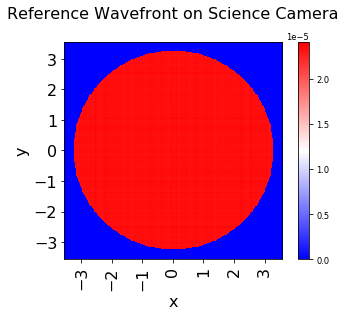

In [9]:
wf_ref = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_ref.total_power = 1
wf_ref_shwfs_fws = shwfs.forward(wf_ref) 
#wf_ref_shwfs_img = wf_ref_shwfs_fws.power

camera.integrate(wf_ref_shwfs_fws,1)
wf_ref_shwfs_img = camera.read_out()

shwf_refeference_position = shwfse.estimate([wf_ref_shwfs_img]).ravel()
num_measurements = shwf_refeference_position.shape[0]




# Final reference image is divided by the total sume
# to normalize the wavefron sensor response. Doing this
# consequently for all exposures will make sure that we
# can use this reference for arbitrary exposure times
# and photon flux
wf_ref_shwfs_img /= wf_ref_shwfs_img.sum()
imshow_field(wf_ref_shwfs_img, cmap = 'bwr')
plt.colorbar()
plt.title('Reference Wavefront on Science Camera\n', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [10]:
# Create the interaction matrix
probe_amp = 0.01*wavelength_wfs
slopes = []
wf_ref = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_ref.total_power = 1

Intmat = []


for ind in range(num_modes):
    if (ind+1)%10 == 0:
        print("Mesasure response to mode {:d}/{:d}\n".format(ind+1, num_modes))
    
    # slope = 0
    total_slopes = np.zeros((num_measurements,))

    
    # Probe the phase response
    for s  in [-1, 1]:
        amp = np.zeros((num_modes, ))
        amp[ind] = s * probe_amp # Actuator Level
        
        deformable_mirror.actuators = amp
        
        dm_wf = deformable_mirror.forward(wf_ref)
        wfs_wf = shwfs.forward(dm_wf)
        
        camera.integrate(wfs_wf, 1)
        image = camera.read_out()
        image /= np.sum(image)
        
        lenslet_centers = shwfse.estimate([image])
        total_slopes += (lenslet_centers.ravel() - shwf_refeference_position)/(2 * amp[ind])
        
        #if (ind+1)%10 == 0:
        #    imshow_field(image, cmap = 'bwr')
        #    plt.colorbar()
        #    plt.title('Science Camera Image at iteration {}/{}\n'.format(ind, s), fontsize=16)
        #    plt.xlabel('x', fontsize = 16)
        #    plt.ylabel('y', fontsize = 16)
        #    xticks = plt.xticks(fontsize=16, rotation=90)
        #    yticks = plt.yticks(fontsize=16, rotation=0)
        #    plt.show()
                
    Intmat.append(total_slopes)

Intmat = ModeBasis(Intmat)



Mesasure response to mode 10/80

Mesasure response to mode 20/80

Mesasure response to mode 30/80

Mesasure response to mode 40/80

Mesasure response to mode 50/80

Mesasure response to mode 60/80

Mesasure response to mode 70/80

Mesasure response to mode 80/80



In [11]:
reconstruction_matrix = inverse_tikhonov(Intmat.transformation_matrix, rcond = 1e-7)

In [12]:
### Initialize the wavefront

In [13]:
wf_wfs = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_wfs.total_power = zero_magnitude_flux*10**(-stellar_magnitude/2.5)

print("Total photon flux {:g}".format(wf_wfs.total_power))

# Put random shape on Deformable Mirror to have something corrected.
deformable_mirror.random(0.1 * wavelength_wfs)

Total photon flux 3.9e+10


In [14]:
AO_Frequency = 1000
delta_t = 1.0 /AO_Frequency
leakage = 0.01
gain = 0.5


In [15]:
input_opd = deformable_mirror.opd
print(input_opd)
print(len(input_opd))

[ 3.32986516e-08  3.50744491e-08  3.69173372e-08 ... -2.40460070e-08
 -2.29128765e-08 -2.18159778e-08]
65536


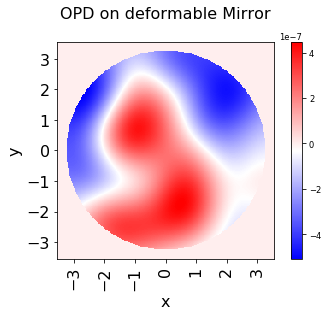

In [16]:

input_opd = telescope_aperture_grid*(input_opd - np.mean(input_opd[telescope_aperture_grid>0]))
imshow_field(input_opd, cmap = 'bwr')
plt.colorbar()
plt.title('OPD on deformable Mirror\n', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()



In [17]:
input_phase_rms = 2*np.pi / wavelength_wfs*np.std(input_opd[telescope_aperture_grid>0])

spatial_resolution = wavelength_wfs/telescope_diameter
focal_grid = make_focal_grid(q = 8, num_airy = 20, 
                            spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(telescope_pupil_grid, focal_grid)
wf_prop = propagator.forward(wf_wfs)
Inorm = wf_prop.power.max()
PSF_in = propagator.forward(deformable_mirror.forward(wf_wfs)).power/Inorm

input_strel = PSF_in.max()

In [18]:
gain = 0.5
## Run the system in closed loop.
for i in range(100):
    wf_dm = deformable_mirror(wf_wfs)
    wf_sh = shwfs.forward(wf_dm)
        
    camera.integrate(wfs_wf, 1)
    image = camera.read_out()
    image /= np.sum(image)
        
    
    # Estimate
    meas_vec = shwfse.estimate([image])
    meas_vec = meas_vec.ravel()
    
    
    camera.integrate(wf_sh, 1)
    wfs_image = large_poisson( camera.read_out() ).astype(np.float)
    wfs_image /= np.sum(wfs_image)
    
    #imshow_field(image, cmap = 'bwr')
    #plt.colorbar()
    #plt.title('Science Camera Image at iteration {}/{}\n'.format(i, 10), fontsize=16)
    #plt.xlabel('x', fontsize = 16)
    #plt.ylabel('y', fontsize = 16)
    #xticks = plt.xticks(fontsize=16, rotation=90)
    #yticks = plt.yticks(fontsize=16, rotation=0)
    #plt.show()
        
    change_in_actuators = reconstruction_matrix.dot(meas_vec - shwf_refeference_position)
    change_in_actuators -= change_in_actuators.mean()
    deformable_mirror.actuators = (1- leakage)*deformable_mirror.actuators - gain * change_in_actuators
    
    
flattened_wf= deformable_mirror.forward(wf_wfs)
PSF_out = propagator.forward(flattened_wf).power/Inorm

In [19]:
PSF_out

Field([1.25353585e-06, 1.89199156e-06, 2.34119169e-06, ...,
       6.05644196e-07, 1.68774036e-06, 2.99729310e-06])

In [20]:
## Comparison

residual_opd = deformable_mirror.opd
residual_opd = telescope_aperture_grid*(residual_opd - np.mean(residual_opd[telescope_aperture_grid>0]))

phase_rms = 2*np.pi/wavelength_wfs*np.std(residual_opd[telescope_aperture_grid>0])
strehl = PSF_out.max()

print("Estimated Strehl Input {:g} and Output {:g}".format(
input_strel, strehl))

Estimated Strehl Input 0.189353 and Output 0.329219


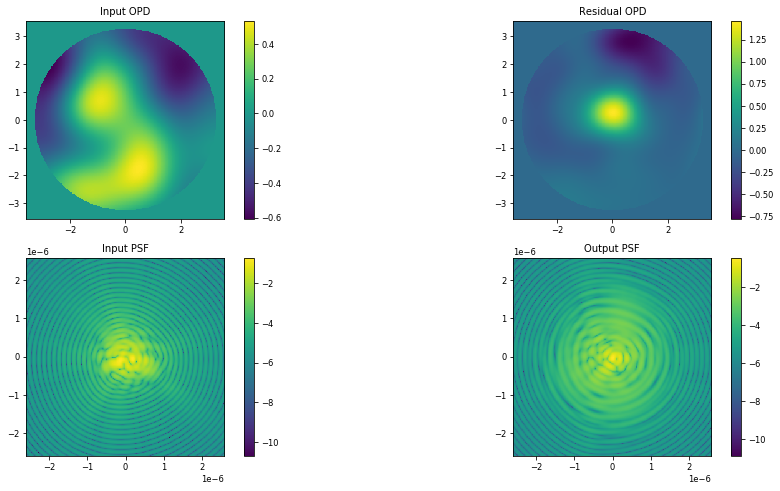

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
imshow_field(input_opd/wavelength_wfs)
plt.title('Input OPD')
plt.colorbar()

plt.subplot(2,2,2)
imshow_field(residual_opd/wavelength_wfs)
plt.title('Residual OPD')
plt.colorbar()

plt.subplot(2,2,3)
imshow_field(np.log10(PSF_in))
plt.title('Input PSF')
plt.colorbar()

plt.subplot(2,2,4)
imshow_field(np.log10(PSF_out))
plt.title('Output PSF')
plt.colorbar()
